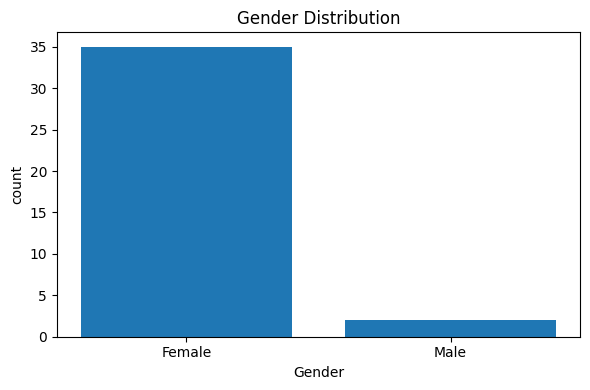

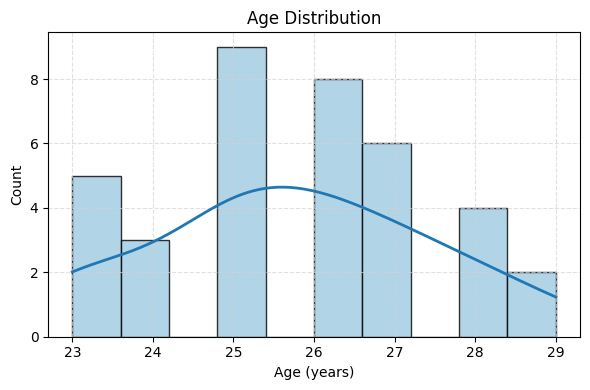

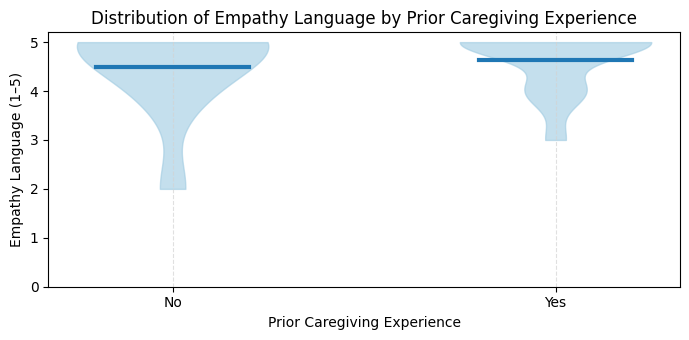

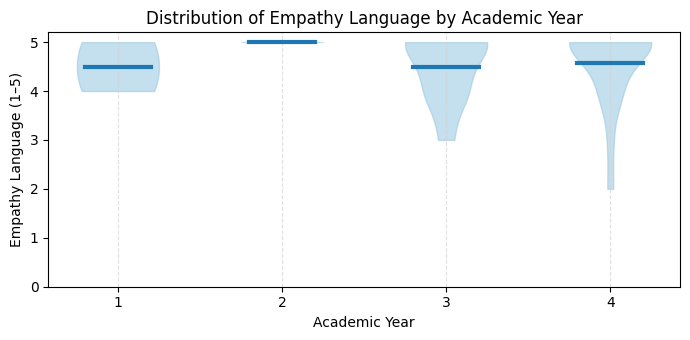

: 

In [ ]:
# recreate_graphs_exact.py
# Requires: pandas, matplotlib, (optional) scipy for KDE curve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

try:
    from scipy.stats import gaussian_kde
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

# ---------- Load data ----------
excel_path = "records_informations.xlsx"  # change if needed
df = pd.read_excel(excel_path)

# Column names in your file
COL_GENDER   = "Gender"
COL_AGE      = "Age (years)"
COL_YEAR     = "Academic year"
COL_CARE     = "Work experience in caring for a person in need of assistance or support"
COL_EMPATHY  = "Using compassionate and empathetic language"

# Prepare columns
gender  = df[COL_GENDER].astype(str).str.strip()
age     = pd.to_numeric(df[COL_AGE], errors="coerce").dropna()
year    = pd.to_numeric(df[COL_YEAR], errors="coerce")
care    = df[COL_CARE].astype(str).str.strip()
empathy = pd.to_numeric(df[COL_EMPATHY], errors="coerce")

# Colors (match your screenshots)
BLUE       = "#1f77b4"  # line/primary blue
LIGHT_BLUE = "#9ecae1"  # histogram/violin fill

# ---------- 1) Gender Distribution ----------
fig, ax = plt.subplots(figsize=(6, 4))
order  = ["Female", "Male"]
counts = gender.value_counts().reindex(order).fillna(0)
ax.bar(counts.index, counts.values, color=BLUE)
ax.set_title("Gender Distribution")
ax.set_xlabel("Gender")
ax.set_ylabel("count")
fig.tight_layout()
plt.savefig("gender_distribution_recreated.png", dpi=150)
plt.show()

# ---------- 2) Age Distribution (hist + KDE in BLUE) ----------
fig, ax = plt.subplots(figsize=(6, 4))
bins = 10
# Light blue bars with black edges
ax.hist(age, bins=bins, edgecolor="black", alpha=0.8, color=LIGHT_BLUE)
ax.set_title("Age Distribution")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Count")
ax.grid(True, which="both", axis="both", linestyle="--", color="lightgray", alpha=0.7)

# KDE curve in BLUE (not orange)
if HAVE_SCIPY and len(age) > 1:
    x_vals = np.linspace(age.min(), age.max(), 200)
    kde = gaussian_kde(age)
    y = kde(x_vals) * len(age) * (age.max() - age.min()) / bins
    ax.plot(x_vals, y, color=BLUE, linewidth=2)

fig.tight_layout()
plt.savefig("age_distribution_recreated.png", dpi=150)
plt.show()

# ---------- 3) Violin: Empathy × Prior Caregiving ----------
groups = ["No", "Yes"]
data_by_care = [empathy[care.str.lower() == g.lower()].dropna().values for g in groups]

fig, ax = plt.subplots(figsize=(7, 3.5))
vp = ax.violinplot(data_by_care, showmeans=False, showmedians=False, showextrema=False)
for b in vp["bodies"]:
    b.set_facecolor(LIGHT_BLUE)
    b.set_edgecolor(LIGHT_BLUE)
    b.set_alpha(0.6)
# blue mean stripe
for i, vals in enumerate(data_by_care, 1):
    if len(vals) > 0:
        m = np.mean(vals)
        ax.plot([i - 0.2, i + 0.2], [m, m], color=BLUE, linewidth=3)

ax.set_xticks([1, 2])
ax.set_xticklabels(groups)
ax.set_title("Distribution of Empathy Language by Prior Caregiving Experience")
ax.set_xlabel("Prior Caregiving Experience")
ax.set_ylabel("Empathy Language (1–5)")
ax.set_ylim(0, 5.2)
ax.grid(True, axis="x", linestyle="--", color="lightgray", alpha=0.7)
fig.tight_layout()
plt.savefig("violinplot_caregiving_experience_recreated.png", dpi=150)
plt.show()

# ---------- 4) Violin: Empathy by Academic Year ----------
years_order = [1, 2, 3, 4]
years_present = [y for y in years_order if y in set(year.dropna().astype(int))]
data_by_year = [empathy[year.astype(float) == y].dropna().values for y in years_present]

fig, ax = plt.subplots(figsize=(7, 3.5))
vp2 = ax.violinplot(data_by_year, showmeans=False, showmedians=False, showextrema=False)

for body in vp2["bodies"]:
    body.set_facecolor(LIGHT_BLUE)
    body.set_edgecolor(LIGHT_BLUE)
    body.set_alpha(0.6)

# blue mean lines
for i, vals in enumerate(data_by_year, start=1):
    if len(vals) > 0:
        m = np.mean(vals)
        ax.plot([i - 0.2, i + 0.2], [m, m], color=BLUE, linewidth=3)

ax.set_xticks(range(1, len(years_present) + 1))
ax.set_xticklabels([str(y) for y in years_present])
ax.set_title("Distribution of Empathy Language by Academic Year")
ax.set_xlabel("Academic Year")
ax.set_ylabel("Empathy Language (1–5)")
ax.set_ylim(0, 5.2)
ax.grid(True, axis="x", linestyle="--", color="lightgray", alpha=0.7)

fig.tight_layout()
plt.savefig("violinplot_academic_year_recreated.png", dpi=150)
plt.show()

In [2]:
!pip install openpyxl  # Ensure openpyxl is installed for Excel reading

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [ ]:
# -------------------------------------------
# Empathy score evaluation (1–5 scale)
# -------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ==== FILE & COLUMN NAMES (edit if yours differ) ====
FILE_PATH = "records_informations.xlsx"
SHEET = "Sheet1"
LABEL_COL = "Using compassionate and empathetic language"
PRED_COL  = "gpt_empathy score"

# ==== LOAD DATA ====
df = pd.read_excel(FILE_PATH, sheet_name=SHEET)

# keep only rows with numeric label & prediction
df = df[[LABEL_COL, PRED_COL]].copy()
df = df.apply(pd.to_numeric, errors="coerce").dropna()

y_true = df[LABEL_COL].astype(float).to_numpy()
y_pred = df[PRED_COL].astype(float).to_numpy()

# ==== ERRORS & METRICS ====
abs_err = np.abs(y_true - y_pred)
mae = abs_err.mean()
std_err = abs_err.std(ddof=0)  # population std
rmse = mean_squared_error(y_true, y_pred, squared=False)

# Random baseline (uniform between 1 and 5 inclusive)
rng = np.random.default_rng(42)     # reproducible
y_rand = rng.integers(1, 6, size=len(y_true))
rmse_rand = mean_squared_error(y_true, y_rand, squared=False)

# Optional constant baselines
y_const_mean = np.full_like(y_true, fill_value=y_true.mean())
rmse_const_mean = mean_squared_error(y_true, y_const_mean, squared=False)

mode_val = pd.Series(y_true).mode().iloc[0]
y_const_mode = np.full_like(y_true, fill_value=mode_val)
rmse_const_mode = mean_squared_error(y_true, y_const_mode, squared=False)

print(f"Samples: {len(y_true)}")
print(f"MAE:  {mae:.3f}")
print(f"STD(error): {std_err:.3f}")
print(f"RMSE (GPT): {rmse:.3f}")
print(f"RMSE (Random 1–5): {rmse_rand:.3f}")
print(f"RMSE (Const=mean={y_true.mean():.2f}): {rmse_const_mean:.3f}")
print(f"RMSE (Const=mode={mode_val:.0f}): {rmse_const_mode:.3f}")

# ==== PLOTS ====

# 1) Histogram of absolute errors
plt.figure(figsize=(6,4))
plt.hist(abs_err, bins=range(0,6), align="left", rwidth=0.8, edgecolor="black")
plt.xticks(range(0,6))
plt.xlabel("Absolute Error (scale 1–5)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.tight_layout()
plt.show()

# 2) Bar with mean ± 1 std of error
plt.figure(figsize=(6,4))
plt.bar(["Error"], [mae], yerr=[std_err], capsize=10, edgecolor="black")
plt.ylabel("Error (scale 1–5)")
plt.title("Mean Absolute Error with Standard Deviation")
plt.tight_layout()
plt.show()

# 3) RMSE comparison: GPT vs Random (and optional constants)
labels = ["GPT", "Random", "Const-Mean", "Const-Mode"]
vals = [rmse, rmse_rand, rmse_const_mean, rmse_const_mode]

plt.figure(figsize=(7,4))
bars = plt.bar(labels, vals, edgecolor="black")
for i, v in enumerate(vals):
    plt.text(i, v + 0.03, f"{v:.2f}", ha="center", va="bottom", fontsize=10)
plt.ylabel("RMSE (scale 1–5)")
plt.title("RMSE Comparison")
plt.tight_layout()
plt.show()
